In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np

# plotting and visuals
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import re
import string
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# Download required NLTK data
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# sklearn
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Plot_roc_curves
from IPython.display import display, HTML
from sklearn.metrics import roc_curve, auc

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

class DataSourcing:
    """Class that loads & gives an understanding of the dataset"""
    def __init__(self):
        pass

    def open_file(self, path):
        """Loading the data"""
        data = pd.read_csv(path, encoding='latin-1')
        return data

    def dataframe_details(self, df):
        """Prints details of the dataframe"""
        self.df = df
        # Info
        print("INFO")
        print("-"*4)
        self.df.info()

        # Shape
        print("\n\nSHAPE")
        print("-"*5)
        print(f"Records in dataset are {self.df.shape[0]} with {self.df.shape[1]} columns.")

        # Columns
        print("\n\nCOLUMNS")
        print("-"*6)
        print("Columns in the dataset are:")
        for idx in self.df.columns:
            print(f"- {idx}")

        # Unique Values
        print("\n\nUNIQUE VALUES")
        print("-"*12)
        for col in self.df.columns:
            print(f"Column *{col}* has {self.df[col].nunique()} unique values")
            if self.df[col].nunique() < 12:
                print(f"Top unique values in the *{col}* include:")
                for idx in self.df[col].value_counts().index:
                    print(f"- {idx}")
            print("")

        # Missing or Null Values
        print("\nMISSING VALUES")
        print("-"*15)
        for col in self.df.columns:
            print(f"Column *{col}* has {self.df[col].isnull().sum()} missing values.")

        # Duplicate Values
        print("\n\nDUPLICATE VALUES")
        print("-"*16)
        print(f"The dataset has {self.df.duplicated().sum()} duplicated records.")


class DataPreprocessing(DataSourcing):
    """Data Preprocessing class that inherits from the data sourcing class.
    Contains functions to be used to check certain aspects in the data for cleaning.
    Checks for duplicates & nulls
    """
    
    def __init__(self):
        super().__init__()

    
    def is_corrupted(self, tweet_column):
        """
        Identifies corrupted records in the specified tweet column.
        
        Args:
            tweet_column (pandas.Series): The column containing tweet text.
        
        Returns:
            list: Indexes of corrupted records.
        """
        corrupted_indices = []
        for idx, text in enumerate(tweet_column):
            if any(ord(char) > 127 for char in str(text)):
                corrupted_indices.append(idx)
        return corrupted_indices

    def drop_bad_reaction_records(self, df):
        """Drops records where the emotion column has 'I can't tell'"""
        self.df = df
        bad_reaction_idx = self.df[self.df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"].index
        self.df.drop(index=bad_reaction_idx, inplace=True)
        return self.df

    def replace_no_emotion(self, df):
        """Replaces 'No emotion toward brand or product' with 'Neutral emotion'"""
        self.df = df
        neutral_reaction_idx = self.df[self.df['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"].index
        self.df.loc[neutral_reaction_idx, 'is_there_an_emotion_directed_at_a_brand_or_product'] = "Neutral emotion"
        return self.df

    def drop_missing_tweet_text(self, df):
        """Drops records with missing tweet_text"""
        self.df = df
        tweet_missing = self.df[self.df['tweet_text'].isnull()].index
        self.df.drop(index=tweet_missing, inplace=True)
        return self.df

    def fill_missing_product(self, df):
        """Fills missing values in emotion_in_tweet_is_directed_at column"""
        self.df = df
        products = list(self.df.emotion_in_tweet_is_directed_at.unique())
        products.remove(np.nan)  # Removes any np.nan items

        def find_product(tweet):
            for product in products:
                if str(product) in tweet or str(product).upper() in tweet \
                        or str(product).lower() in tweet or str(product).title() in tweet:
                    return product

        missing_products_idx = self.df[self.df['emotion_in_tweet_is_directed_at'].isnull()].index
        self.df.loc[missing_products_idx, 'emotion_in_tweet_is_directed_at'] = self.df.loc[missing_products_idx, 'tweet_text'].apply(lambda x: find_product(x))
        none_index = self.df[self.df['emotion_in_tweet_is_directed_at'].isnull()].index
        self.df.loc[none_index, 'emotion_in_tweet_is_directed_at'] = 'None'
        return self.df

    def drop_duplicates(self, df):
        """Drops duplicate records"""
        self.df = df
        self.df.drop_duplicates(inplace=True)
        return self.df

    def rename_columns(self, df):
        """Renames columns"""
        self.df = df
        self.df.rename(columns={
            'tweet_text': "tweet",
            'emotion_in_tweet_is_directed_at': "product",
            'is_there_an_emotion_directed_at_a_brand_or_product': "emotion"
        }, inplace=True)
        return self.df

    def reset_index(self, df):
        """Resets the index of the dataframe"""
        self.df = df
        self.df.reset_index(drop=True, inplace=True)
        return self.df

    def lemmatize_tweet(self, text):
        """
        Lemmatizes tweet text by removing URLs, mentions, hashtags, special characters,
        punctuation, stopwords, and lemmatizing tokens.
        
        Args:
            text (str): The tweet text to be lemmatized.
        
        Returns:
            list: List of lemmatized tokens.
        """
        stop_words = set(stopwords.words('english') + ['sxsw', 'sxswi', 'link', 'rt'])
        lemmatizer = WordNetLemmatizer()

        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove mentions
        text = re.sub(r'@\w+', '', text)
        # Remove hashtags (keep the text after the #)
        text = re.sub(r'#', '', text)
        # Remove special characters like "&quot;"
        text = re.sub(r'&\w+;', '', text)
        # Remove punctuation
        text = "".join([char for char in text if char not in string.punctuation])
        # Tokenize text
        tokens = re.split('\W+', text.lower())
        # Remove stopwords and lemmatize the tokens
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        # Remove extra white spaces
        tokens = [word.strip() for word in tokens if word.strip() != '']
        # Remove numbers
        tokens = [word for word in tokens if not word.isdigit()]
        # Tag parts of speech
        pos_tags = nltk.pos_tag(tokens)
        # Filter tokens to retain only nouns, adjectives, verbs, and adverbs
        important_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS'}
        tokens = [word for word, tag in pos_tags if tag in important_pos]
        return tokens
    
    def join_text(self, tokens):
        """
        Joins a list of tokens into a single string separated by spaces.
        
        Args:
            tokens (list of str): List of tokens to be joined.
        
        Returns:
            str: The tokens joined into a single string.
        """
        return " ".join(tokens)
    
# Class for Data Visualization and Analysis
class DataAnalysis(DataPreprocessing, DataSourcing):
    """
    Data Analysis class that inherits from the DataPreprocessing and DataSourcing classes.
    Contains methods for plotting, frequency distribution, bigrams, and word clouds.
    """
    
    def __init__(self, data=None):
        super().__init__()
        data=data
    
    def plot_bar(self, df, feature, plot='bar'):
        """
        Plots a bar or horizontal bar (barh) chart for the specified feature.
        
        Args:
            feature (str): The feature/column to plot.
            plot (str, optional): Plot type ('bar' or 'barh'). Defaults to 'bar'.
        """
        self.df = df
        if plot == 'bar':
            labels = df[feature].value_counts().index
            values = df[feature].value_counts().values
            plt.bar( x=labels,height=values)
            plt.ylabel("Count")
            plt.xlabel("Categories")
        else:
            labels = df[feature].value_counts(ascending=True).index
            values = df[feature].value_counts(ascending=True).values
            plt.barh(width=values, y=labels)
            plt.xlabel("Count")
            plt.ylabel("Categories")
        plt.title(f"Distribution of the {feature.title()} feature");    
    def plot_fdist(self, sentiment=None, title="Frequency Distribution of All Words"):
        """
        Creates a frequency distribution plot based on the specified sentiment.
        
        Args:
            sentiment (str, optional): Sentiment category (e.g., 'positive', 'negative'). Defaults to None.
            title (str, optional): Title for the plot. Defaults to "Frequency Distribution of All Words".
        """
        if sentiment == None:
            lemmatized_tweet = df['lemmatized_tweet']

            # Flatten the list
            flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

        elif sentiment != None:
            lemmatized_tweet = df[df['emotion'] == sentiment]['lemmatized_tweet']

            # Flatten the list
            flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

        # Create the frequency distribution
        fdist = FreqDist(flattened_lemmatized_tweet)

        # Plot the frequency distribution
        plt.figure(figsize=(10,6))
        plt.title(title, fontsize=14)
        fdist.plot(30);
    def bigram_plots(self, sentiment=None, title="Bigram of The Data - All Sentiments", items=20):
        """
        Creates a horizontal plot of the highest scored bigrams in the dataset.
        
        Args:
            sentiment (str, optional): Sentiment category (e.g., 'positive', 'negative'). Defaults to None.
            title (str, optional): Title for the plot. Defaults to "Bigram of The Data - All Sentiments".
            items (int, optional): Number of top bigrams to display. Defaults to 20.
        """
        
        # Alias for BigramAssocMeasures
        bigram_measures = BigramAssocMeasures()

        if sentiment == None:
            lemmatized_tweet = df['lemmatized_tweet']

            # Flatten the list
            flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

        elif sentiment != None:
            lemmatized_tweet = df[df['emotion'] == sentiment]['lemmatized_tweet']

            # Flatten the list
            flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

        # Create BigramCollocationFinder
        finder = BigramCollocationFinder.from_words(flattened_lemmatized_tweet)

        # Score bigrams by raw frequency
        scored = finder.score_ngrams(bigram_measures.raw_freq)


        # Order the bigrams
        scores = sorted(scored[:items], key=lambda x: x[1])

        # labels and width
        labels, score = [b[0] + " " + b[1] for b, _ in scores], [score for _, score in scores]

        # Plot
        plt.figure(figsize=(10,6))
        plt.title(title, fontsize=14)
        plt.ylabel("Bigrams")
        plt.xlabel("Scores")
        plt.barh(y=labels, width=score);

    def create_word_cloud(self, lemmatized_tweet, max_words=1000, width=1600, height=800):
        """
        Generates and displays a word cloud from the lemmatized tweets.
        
        Args:
            lemmatized_tweet (list of list): Lemmatized tweet tokens.
            max_words (int, optional): Maximum number of words in the word cloud. Defaults to 1000.
            width (int, optional): Width of the word cloud image. Defaults to 1600.
            height (int, optional): Height of the word cloud image. Defaults to 800.
        """
        
        lemmatized_tweet = df['lemmatized_tweet']

        # Flatten the list
        flattened_lemmatized_tweet = [token for sublist in lemmatized_tweet for token in sublist]

        # Use all processed text directly
        data_neg = flattened_lemmatized_tweet[:len(flattened_lemmatized_tweet)]

        # Create the word cloud
        plt.figure(figsize = (20,20))
        wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
                    collocations=False).generate(" ".join(data_neg))

        # Display the word cloud
        plt.imshow(wc)
        plt.axis('off')  # Hide axes
        plt.show()

class DataModeling(DataAnalysis, DataPreprocessing, DataSourcing):
    def __init__(self, data=None):
        super().__init__(data)

    def label_encode_target(self, target_column):
        label_encoder = LabelEncoder()
        return label_encoder.fit_transform(target_column)

    def vectorize_data(self, text_column, method='count'):
        if method == 'count':
            cv = CountVectorizer()
            X_vec = cv.fit_transform(text_column)
            X_vec = pd.DataFrame.sparse.from_spmatrix(X_vec)
            X_vec.columns = sorted(cv.vocabulary_)
        elif method == 'tfidf':
            tf = TfidfVectorizer()
            X_vec = tf.fit_transform(text_column)
            X_vec = pd.DataFrame.sparse.from_spmatrix(X_vec)
            X_vec.columns = sorted(tf.vocabulary_)
        return X_vec

    def apply_smote(self, X, y):
        smote = SMOTE()
        return smote.fit_resample(X, y)

    def modeling(self, model, X_train, y_train, X_test, y_test, cv=False, tf=False):
        if cv:
            model.fit(X_train_cv, y_train_cv)
            y_hat = model.predict(X_test_cv)
            print("Count Vectorisation Results\n")
            print("Main Metrics")
            print("-"*12)
            print(f"Accuracy Score {round(accuracy_score(y_test_cv, y_hat), 3)}")
            print(f"Recall Score {round(recall_score(y_test_cv, y_hat, average='macro'), 3)}")
            print("\nClassification Report")
            print(classification_report(y_test_cv, y_hat))
        elif tf:
            model.fit(X_train_tf, y_train_tf)
            y_hat = model.predict(X_test_tf)
            print("---------")
            print("TFIDF Vectorisation Results\n")
            print("Main Metrics")
            print("-"*12)
            print(f"Accuracy Score {round(accuracy_score(y_test_tf, y_hat), 3)}")
            print(f"Recall Score {round(recall_score(y_test_tf, y_hat, average='macro'), 3)}")
            print("\nClassification Report")
            print(classification_report(y_test_tf, y_hat))

    def hyper_tuning(self, model, params, X_train_cv, y_train_cv, X_test_cv, y_test_cv, X_train_tf, y_train_tf, X_test_tf, y_test_tf, model_name="Random Forest"):
        grid_search_model = GridSearchCV(model, params, cv=5, scoring='accuracy')
        
        # Count Vectorisation
        grid_search_rf_cv = grid_search_model.fit(X_train_cv, y_train_cv)
        best_rf_model_cv = grid_search_rf_cv.best_estimator_
        y_pred_cv = best_rf_model_cv.predict(X_test_cv)
        accuracy_cv = accuracy_score(y_test_cv, y_pred_cv)
        recall_cv = recall_score(y_test_cv, y_pred_cv, average='macro')
        
        print("Count Vectorisation Results\n")
        print(f"Best {model_name.title()} Model (Count Vectorization):\n", best_rf_model_cv)
        print(f"\nTest Accuracy (Count Vectorization): {accuracy_cv:.3f}")
        print(f"\nTest Recall (Count Vectorization): {recall_cv:.3f}")
        print("---------")

        # TFIDF Vectorisation
        grid_search_rf_tf = grid_search_model.fit(X_train_tf, y_train_tf)
        best_rf_model_tf = grid_search_rf_tf.best_estimator_
        y_pred_tf = best_rf_model_tf.predict(X_test_tf)
        accuracy_tf = accuracy_score(y_test_tf, y_pred_tf)
        recall_tf = recall_score(y_test_tf, y_pred_tf, average='macro')
        
        print("\n\nTFIDF Vectorisation Results\n")
        print(f"Best {model_name.title()} Model (TFIDF Vectorization):\n", best_rf_model_tf)
        print(f"\nTest Accuracy (TFIDF Vectorization): {accuracy_tf:.3f}")
        print(f"\nTest Recall (TFIDF Vectorization): {recall_tf:.3f}")

        return best_rf_model_cv, best_rf_model_tf

    def plot_roc_curves(self, models, X_train_resampled, y_train_resampled, X_test, y_test, X_train_params=None, y_train_params=None):
        '''
        Plots ROC curves for the given models.

        Parameters:
        models (list): List of models to plot ROC curves for.
        X_train_resampled (array-like): Resampled training features.
        y_train_resampled (array-like): Resampled training labels.
        X_test (array-like): Test features.
        y_test (array-like): Test labels.
        X_train_params (array-like, optional): Custom parameters for X_train_resampled.
        y_train_params (array-like, optional): Custom parameters for y_train_resampled.
        '''
        # Use custom parameters if provided, otherwise use default
        X_train = X_train_params if X_train_params is not None else X_train_resampled
        y_train = y_train_params if y_train_params is not None else y_train_resampled

        plt.figure(figsize=(10, 8))
        
        for model in models:
            model.fit(X_train, y_train)
            
            # Predict probabilities for positive class
            y_prob = model.predict_proba(X_test)[:, 1]
            
            # Compute ROC curve and ROC area
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.show()

In [2]:

ds = DataSourcing()


In [3]:

df = ds.open_file('judge_tweet_product_company.csv')


In [4]:

ds.dataframe_details(df)


INFO
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


SHAPE
-----
Records in dataset are 9093 with 3 columns.


COLUMNS
------
Columns in the dataset are:
- tweet_text
- emotion_in_tweet_is_directed_at
- is_there_an_emotion_directed_at_a_brand_or_product


UNIQUE VALUES
------------
Column *tweet_text* has 9065 unique values

Column *emotion_in_tweet_is_directed_at* has 9 unique values
Top unique values in the *emotion_in_tweet_is_directed_at* include:
- iPad
- Apple
- iPad or iPhone App
-

In [5]:

dp = DataPreprocessing()


In [6]:
corrupted_records_idx = dp.is_corrupted(df['tweet_text'])

In [7]:
# Drop the corrupted records
df.drop(index=corrupted_records_idx, inplace=True)

In [8]:

df = dp.drop_bad_reaction_records(df)


In [9]:

df = dp.replace_no_emotion(df)


In [10]:

df = dp.drop_missing_tweet_text(df)


In [11]:

df = dp.fill_missing_product(df)


In [12]:

df = dp.drop_duplicates(df)


In [13]:

df = dp.rename_columns(df)
df.columns


Index(['tweet', 'product', 'emotion'], dtype='object')

In [14]:

df = dp.reset_index(df)


In [15]:
df.shape

(8439, 3)

In [16]:
# Instantiate the DataAnalysis class
eda = DataAnalysis()

## **Data Analysis**

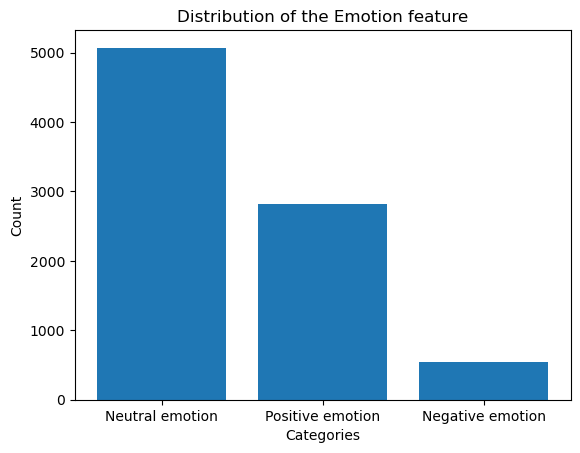

In [17]:
eda.plot_bar(df, feature='emotion', plot='bar')

In [18]:
# Apply lemmatization and token joining to the 'tweet' column
df['lemmatized_tweet'] = df['tweet'].apply(lambda x: dp.lemmatize_tweet(x))
df['clean_tweet'] = df['lemmatized_tweet'].apply(lambda x: dp.join_text(x))


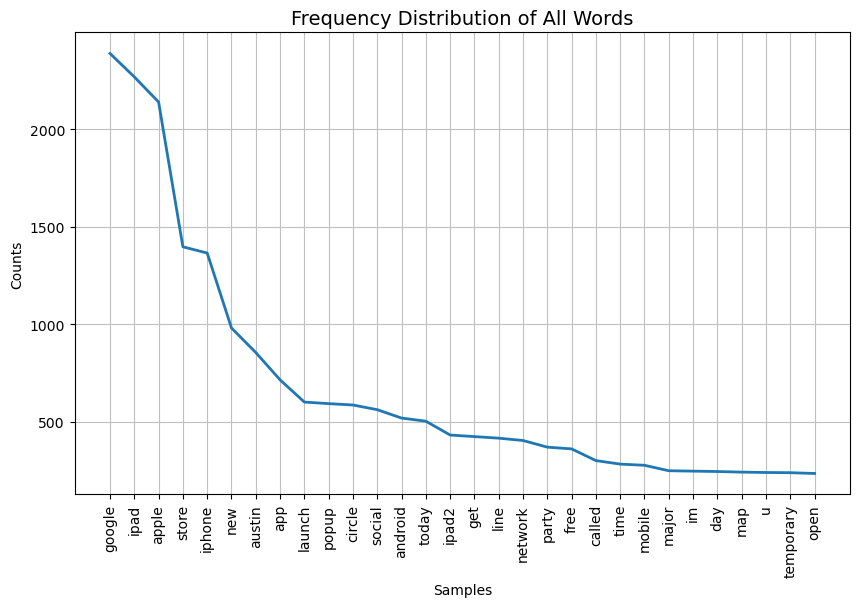

In [19]:
eda.plot_fdist()

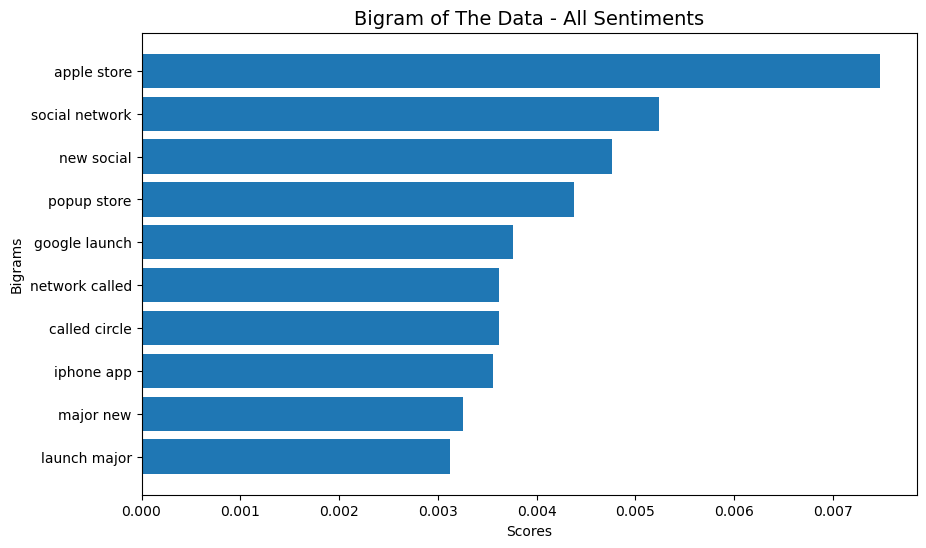

In [20]:
eda.bigram_plots(items=10)

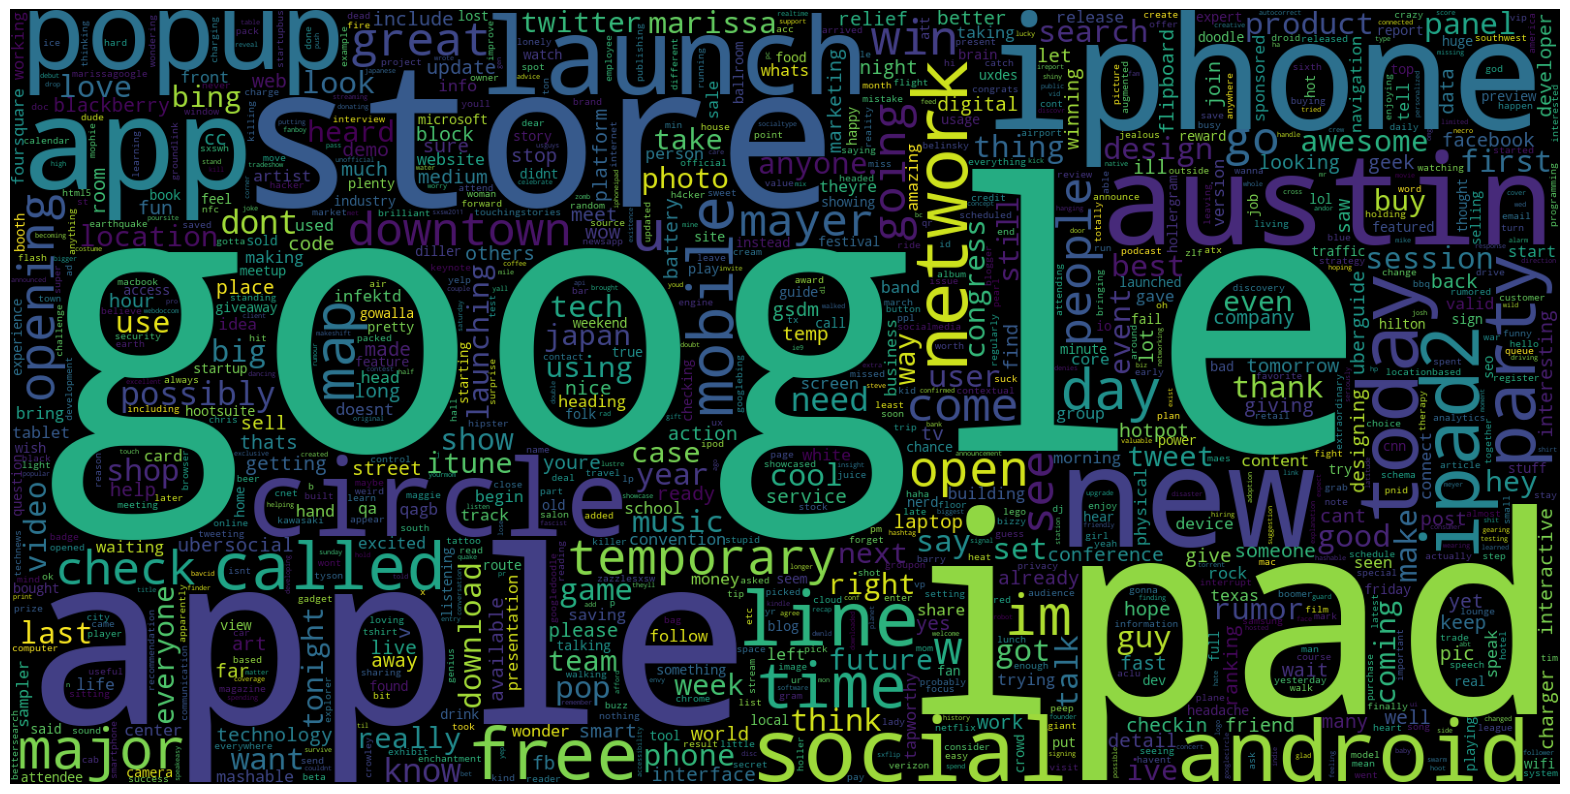

In [21]:
eda.create_word_cloud(lemmatized_tweet=df['lemmatized_tweet'])

## **Data Modeling**

### ***Models***

The machine learning algorithms used in this section are:

- RandomForest
- Naive Bayes(MultinomialNB)
- LogisticRegression
- DecisionTrees

> The data was vectorized using both `CountVectorizer` and `TfidfVectorizer` to see which vectorizer performed better.

> The best performing models were `RandomForestClassifier` & `LogisticRegression`

### ***Random Forest Classifier***

*Before tuning*

*After hyperparameter tuning*

### ***Logistic Regression***

*Before tuning*

*After hyperparameter tuning*